In [1]:
import pandas as pd
from clearml import Task
import numpy as np
import h5py
import os
from pathlib import Path
import re
from datetime import datetime
import dask.dataframe as dd
import gc
import pyarrow.parquet as pq
import pyarrow as pa

def find_latest_h5_file(task_id, base_dir="/scratch/clearml/offline_logs/"):
    """Find the latest h5 file for a given task_id"""
    base_path = Path(base_dir)
    
    pattern = f"metrics_{task_id}*.h5"
    matching_files = list(base_path.glob(pattern))
    
    if not matching_files:
        print(f"  No h5 file found for task {task_id}")
        return None
    
    if len(matching_files) == 1:
        print(f"  Found h5 file: {matching_files[0].name}")
        return matching_files[0]
    
    files_with_timestamps = []
    for file_path in matching_files:
        filename = file_path.name
        timestamp_match = re.search(f"metrics_{task_id}_(.+)\\.h5", filename)
        if timestamp_match:
            timestamp_str = timestamp_match.group(1)
            try:
                timestamp = float(timestamp_str)
            except ValueError:
                try:
                    timestamp = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S").timestamp()
                except:
                    timestamp = float('-inf')
            files_with_timestamps.append((file_path, timestamp))
        else:
            files_with_timestamps.append((file_path, float('-inf')))
    
    latest_file = max(files_with_timestamps, key=lambda x: x[1])[0]
    print(f"  Multiple h5 files found, using latest: {latest_file.name}")
    return latest_file

def debug_h5_structure(h5_path):
    """Debug function to inspect h5 file structure"""
    print(f"\nDEBUGGING H5 FILE: {h5_path}")
    
    with h5py.File(h5_path, 'r') as f:
        def print_structure(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
                print(f"  Shape: {obj.shape}")
                print(f"  Dtype: {obj.dtype}")
                if obj.size < 10:
                    print(f"  Data preview: {obj[:]}")
                else:
                    print(f"  Data preview (first 5): {obj[:5]}")
        
        print("H5 File Structure:")
        f.visititems(print_structure)
        print(f"\nRoot level keys: {list(f.keys())}")

def read_h5_metrics(h5_path):
    """Read metrics from h5 file and return as structured dictionary"""
    metrics = {}
    
    with h5py.File(h5_path, 'r') as f:
        metric_names = set()
        for key in f.keys():
            if not key.endswith('_iterations'):
                metric_names.add(key)
        
        for metric_name in metric_names:
            iteration_key = f"{metric_name}_iterations"
            
            if metric_name in f:
                values = f[metric_name][:]
                iterations = f[iteration_key][:] if iteration_key in f else None
                
                metrics[metric_name] = {
                    'values': values,
                    'iterations': iterations
                }
    
    return metrics

def download_and_process_tasks_from_h5_normalized(tag, experiment_name, base_dir="/scratch/clearml/offline_logs/", 
                                                   debug_first=True, batch_size=20, 
                                                   metadata_path=None, timeseries_path=None, force_download=False):
    """Download tasks and save as normalized tables: metadata + timeseries"""
    print(f"DOWNLOADING TASKS FOR {experiment_name}: {tag}")
    
    if not metadata_path or not timeseries_path:
        raise ValueError("Both metadata_path and timeseries_path are required")
    
    # Check if files already exist
    if not force_download and os.path.exists(metadata_path) and os.path.exists(timeseries_path):
        print(f"\nFound existing files:")
        print(f"  Metadata: {metadata_path}")
        print(f"  Timeseries: {timeseries_path}")
        print(f"Loading as Dask DataFrames...")
        
        df_metadata = dd.read_parquet(metadata_path)
        df_timeseries = dd.read_parquet(timeseries_path)
        
        print(f"\nMetadata DataFrame: {df_metadata.npartitions} partitions")
        print(f"Columns: {df_metadata.columns.tolist()}")
        print(f"Sample:")
        print(df_metadata.head(5))
        
        print(f"\nTimeseries DataFrame: {df_timeseries.npartitions} partitions")
        print(f"Columns: {df_timeseries.columns.tolist()}")
        print(f"Sample:")
        print(df_timeseries.head(5))
        
        return df_metadata, df_timeseries
    
    if force_download:
        print("Force download enabled - will regenerate files")
    
    # Use query_tasks to get all task IDs - filter for completed tasks
    print("Querying all completed task IDs...")
    task_ids = Task.query_tasks(project_name="oho", tags=[tag], task_filter={'status': ['completed'], 'system_tags': ['-archived']})
    print(f"Found {len(task_ids)} completed task IDs (excluding archived)")
    
    # Get full task objects
    print("Loading task objects...")
    tasks = [Task.get_task(task_id=tid) for tid in task_ids]
    print(f"Loaded {len(tasks)} tasks")
    
    print(f"Will save metadata to: {metadata_path}")
    print(f"Will save timeseries to: {timeseries_path}")
    
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)
    os.makedirs(os.path.dirname(timeseries_path), exist_ok=True)
    
    # Remove existing files
    if os.path.exists(metadata_path):
        os.remove(metadata_path)
    if os.path.exists(timeseries_path):
        os.remove(timeseries_path)
    
    h5_files_found = 0
    h5_files_missing = 0
    total_metadata_rows = 0
    total_timeseries_rows = 0
    
    metadata_rows = []
    timeseries_writer = None
    
    for batch_start in range(0, len(tasks), batch_size):
        batch_end = min(batch_start + batch_size, len(tasks))
        batch_tasks = tasks[batch_start:batch_end]
        print(f"\nProcessing batch {batch_start + 1}-{batch_end}/{len(tasks)}")
        
        timeseries_rows = []
        
        for idx, task in enumerate(batch_tasks):
            task_id = task.id
            task_name = task.name
            
            # Metadata row (one per task)
            metadata_row = {"task_id": task_id, "task_name": task_name}
            params = task.get_parameters() or {}
            for key, value in params.items():
                # Added momentum to the list of parameters to extract
                if any(x in key for x in ["learning_rate", "optimizer/_type", "seed/global_seed", "weight_decay", "momentum"]):
                    metadata_row[key] = value
            
            h5_path = find_latest_h5_file(task_id, base_dir)
            
            if h5_path is None:
                h5_files_missing += 1
                metadata_rows.append(metadata_row)
                continue
            
            h5_files_found += 1
            
            if debug_first and h5_files_found == 1:
                debug_h5_structure(h5_path)
            
            try:
                metrics = read_h5_metrics(h5_path)
                
                # Separate scalar (final_*) from timeseries
                scalar_metrics = {}
                timeseries_metrics = {}
                
                for metric_name, metric_data in metrics.items():
                    values = metric_data['values']
                    iterations = metric_data['iterations']
                    
                    if metric_name.startswith('final_'):
                        # Add to metadata
                        scalar_metrics[f"metric/{metric_name}"] = values[0] if len(values) > 0 else np.nan
                    elif iterations is not None and len(values) == len(iterations):
                        timeseries_metrics[metric_name] = metric_data
                
                # Add scalar metrics to metadata row
                metadata_row.update(scalar_metrics)
                metadata_rows.append(metadata_row)
                
                # Create timeseries rows (many per task)
                if timeseries_metrics:
                    ref_metric = list(timeseries_metrics.keys())[0]
                    iterations = timeseries_metrics[ref_metric]['iterations']
                    
                    for iter_idx, iteration in enumerate(iterations):
                        ts_row = {
                            "task_id": task_id,
                            "iteration": int(iteration)
                        }
                        
                        for metric_name, metric_data in timeseries_metrics.items():
                            if iter_idx < len(metric_data['values']):
                                ts_row[f"metric/{metric_name}"] = metric_data['values'][iter_idx]
                        
                        timeseries_rows.append(ts_row)
                
                # Free memory immediately after processing each task
                del metrics
                del scalar_metrics
                del timeseries_metrics
                    
            except Exception as e:
                print(f"  ERROR reading h5 file: {e}")
                import traceback
                traceback.print_exc()
                h5_files_missing += 1
                metadata_rows.append(metadata_row)
        
        # Save timeseries batch using streaming writer
        if timeseries_rows:
            ts_batch_df = pd.DataFrame(timeseries_rows)
            total_timeseries_rows += len(ts_batch_df)
            
            if batch_start == 0:
                # Initialize writer on first batch
                ts_table = pa.Table.from_pandas(ts_batch_df)
                timeseries_writer = pq.ParquetWriter(timeseries_path, ts_table.schema)
                timeseries_writer.write_table(ts_table)
                del ts_table
            else:
                # Append to existing file
                ts_table = pa.Table.from_pandas(ts_batch_df)
                timeseries_writer.write_table(ts_table)
                del ts_table
            
            print(f"  Saved timeseries batch ({len(ts_batch_df)} rows)")
            
            del timeseries_rows
            del ts_batch_df
            gc.collect()
    
    # Close the parquet writer
    if timeseries_writer is not None:
        timeseries_writer.close()
    
    # Save all metadata at once (only 300 rows, no need to batch)
    if metadata_rows:
        metadata_df = pd.DataFrame(metadata_rows)
        metadata_df.to_parquet(metadata_path, index=False)
        total_metadata_rows = len(metadata_df)
        print(f"\nSaved metadata ({total_metadata_rows} rows) to {metadata_path}")
        del metadata_df
        gc.collect()
    
    print(f"\n=== SUMMARY ===")
    print(f"Total tasks: {len(tasks)}")
    print(f"H5 files found: {h5_files_found}")
    print(f"H5 files missing: {h5_files_missing}")
    print(f"Total metadata rows: {total_metadata_rows}")
    print(f"Total timeseries rows: {total_timeseries_rows}")
    
    # Load as Dask DataFrames
    print(f"\nLoading as Dask DataFrames")
    df_metadata = dd.read_parquet(metadata_path)
    df_timeseries = dd.read_parquet(timeseries_path)
    
    print(f"\nMetadata DataFrame: {df_metadata.npartitions} partitions")
    print(f"Columns: {df_metadata.columns.tolist()}")
    print(f"Sample:")
    print(df_metadata.head(5))
    
    print(f"\nTimeseries DataFrame: {df_timeseries.npartitions} partitions")
    print(f"Columns: {df_timeseries.columns.tolist()}")
    print(f"Sample:")
    print(df_timeseries.head(5))
    
    return df_metadata, df_timeseries

In [2]:

# Usage
df_metadata_exp1, df_timeseries_exp1 = download_and_process_tasks_from_h5_normalized(
    tag="opt: 3b236bf171bb448fad041e56380160e9", 
    experiment_name="Fixed LR",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,
    metadata_path="/scratch/clearml/processed_data/fixed_lr_metadata_3b236bf171bb448fad041e56380160e9.parquet",
    timeseries_path="/scratch/clearml/processed_data/fixed_lr_timeseries_3b236bf171bb448fad041e56380160e9.parquet",
    force_download=False,
)


DOWNLOADING TASKS FOR Fixed LR: opt: 3b236bf171bb448fad041e56380160e9

Found existing files:
  Metadata: /scratch/clearml/processed_data/fixed_lr_metadata_3b236bf171bb448fad041e56380160e9.parquet
  Timeseries: /scratch/clearml/processed_data/fixed_lr_timeseries_3b236bf171bb448fad041e56380160e9.parquet
Loading as Dask DataFrames...

Metadata DataFrame: 1 partitions
Columns: ['task_id', 'task_name', 'config/seed/global_seed', 'config/learners/0/optimizer/learning_rate/value', 'config/learners/0/optimizer/learning_rate/learnable', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/clip', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/scale', 'config/learners/0/optimizer/learning_rate/hyperparameter_parametrization/_type', 'config/learners/0/optimizer/weight_decay/value', 'config/learners/0/optimizer/weight_decay/learnable', 'config/learners/0/optimizer/weight_decay/hyperparameter_parametrization/clip', 'config/learners/0/optimizer/weight_d

In [3]:

# Usage
df_metadata_exp2, df_timeseries_exp2 = download_and_process_tasks_from_h5_normalized(
    tag="opt: 5905e673adbb4f678027372eed4f199b", 
    experiment_name="oho",
    base_dir="/scratch/clearml/offline_logs/",
    debug_first=True,
    batch_size=20,
    metadata_path="/scratch/clearml/processed_data/oho_metadata_5905e673adbb4f678027372eed4f199b.parquet",
    timeseries_path="/scratch/clearml/processed_data/oho_timeseries_5905e673adbb4f678027372eed4f199b.parquet",
    force_download=True,
)


DOWNLOADING TASKS FOR oho: opt: 5905e673adbb4f678027372eed4f199b
Force download enabled - will regenerate files
Querying all completed task IDs...
Found 20 completed task IDs (excluding archived)
Loading task objects...
Loaded 20 tasks
Will save metadata to: /scratch/clearml/processed_data/oho_metadata_5905e673adbb4f678027372eed4f199b.parquet
Will save timeseries to: /scratch/clearml/processed_data/oho_timeseries_5905e673adbb4f678027372eed4f199b.parquet

Processing batch 1-20/20
  Found h5 file: metrics_74ca1167bce640cd9151756e5d113ca3_20251112_090932.h5

DEBUGGING H5 FILE: /scratch/clearml/offline_logs/metrics_74ca1167bce640cd9151756e5d113ca3_20251112_090932.h5
H5 File Structure:
Dataset: final_test_accuracy
  Shape: (1,)
  Dtype: float64
  Data preview: [0.95929998]
Dataset: final_test_accuracy_iterations
  Shape: (1,)
  Dtype: int32
  Data preview: [60000]
Dataset: final_test_loss
  Shape: (1,)
  Dtype: float64
  Data preview: [0.14965747]
Dataset: final_test_loss_iterations
  Shape

In [6]:
# Usage
experiments = [
    # ("Fixed LR", df_metadata_exp1, df_timeseries_exp1),
    ("OHO", df_metadata_exp2, df_timeseries_exp2),
]


Processing Fixed LR...
Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']

All configurations ranked by mean final test loss (aggregated across seeds):
--------------------------------------------------------------------------------
Rank 1: learning_rate=0.055696, learning_rate=0.001000, weight_decay=0.000938 | mean=0.138308, std=0.012231, n_seeds=20
Rank 2: learning_rate=0.098726, learning_rate=0.001000, weight_decay=0.000938 | mean=0.142322, std=0.013708, n_seeds=20
Rank 3: learning_rate=0.031421, learning_rate=0.001000, weight_decay=0.000938 | mean=0.143409, std=0.010697, n_seeds=20
Rank 4: learning_rate=0.055696, learning_rate=0.001000, weight_decay=0.000440 | mean=0.147392, std=0.012749, n_seeds=20
Rank 5: learning_rate=0.031421, learning_rate=0.001000, weight_decay=0.000440 | mean=0.147502, std=0.010856, n_seeds=20
Rank 6: learning_rate=0.031421, lea

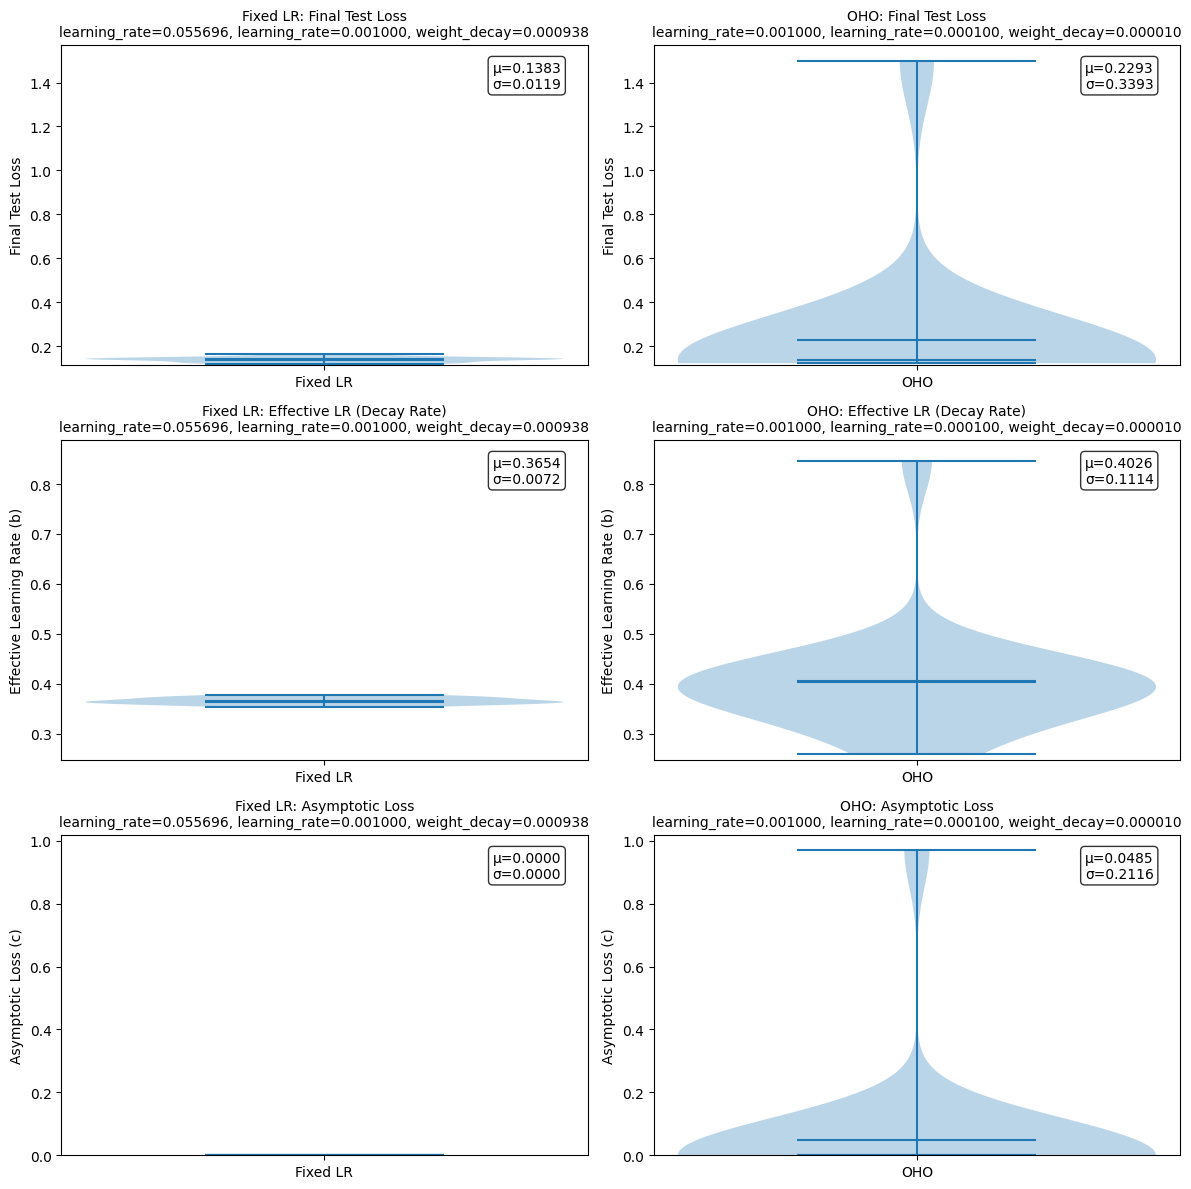

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_final_loss_and_effective_lr_violins(experiments):
    """
    Plot violin plots for final test loss and effective learning rate across experiments.
    Only uses tasks from the BEST configuration based on learning rate, meta learning rate, weight decay, and momentum.
    Memory-efficient version that processes data in chunks and uses Dask operations.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    n_experiments = len(experiments)
    
    all_final_losses = []
    all_eff_lrs = []
    all_asymptotes = []
    experiment_data = []
    
    for name, df_metadata, df_timeseries in experiments:
        print(f"\n{'='*60}")
        print(f"Processing {name}...")
        print(f"{'='*60}")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
            # 'config/learners/1/optimizer/momentum'
        ]
        
        # Check which columns exist (compute only column names)
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"Using configuration columns: {available_cols}")
        
        # Group by config and get mean final test loss using Dask
        # This aggregates across ALL seeds for each unique config
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'std', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        
        print(f"\nAll configurations ranked by mean final test loss (aggregated across seeds):")
        print("-" * 80)
        for rank, (_, row) in enumerate(config_summary.iterrows(), start=1):
            config_str = ", ".join([f"{col.split('/')[-2] if 'momentum' in col else col.split('/')[-2]}={float(row[col]):.6f}" for col in available_cols])
            print(f"Rank {rank}: {config_str} | "
                f"mean={row['mean']:.6f}, std={row['std']:.6f}, n_seeds={int(row['count'])}")
        
        # Best config is the one with LOWEST mean final test loss across all seeds
        best_config = config_summary.iloc[0]
        config_str = ", ".join([f"{col.split('/')[-2] if 'momentum' in col else col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        
        print(f"\n{'*'*80}")
        print(f"BEST CONFIG: {config_str}")
        print(f"Mean final test loss: {best_config['mean']:.6f}")
        print(f"Number of seeds: {int(best_config['count'])}")
        print(f"{'*'*80}")
        
        # Filter metadata to best config using Dask - gets ALL tasks with this exact config (all seeds)
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'metric/final_test_loss']].compute()
        
        # Get final test losses for best config (one per seed)
        final_losses = best_metadata['metric/final_test_loss'].dropna().values
        best_task_ids = best_metadata['task_id'].values
        
        print(f"\nProcessing {len(best_task_ids)} tasks (seeds) for effective learning rate...")
        
        # Compute effective learning rates and asymptotes from test loss curves for best config tasks
        # Process in chunks to avoid memory issues
        eff_lrs = []
        asymptotes = []
        chunk_size = 10
        
        for i in range(0, len(best_task_ids), chunk_size):
            chunk_ids = best_task_ids[i:i+chunk_size]
            # Filter timeseries for this chunk using Dask
            chunk_timeseries = df_timeseries[df_timeseries['task_id'].isin(chunk_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
            
            for task_id in chunk_ids:
                task_data = chunk_timeseries[chunk_timeseries['task_id'] == task_id]
                if len(task_data) > 5:
                    try:
                        iterations = task_data['iteration'].values
                        test_losses = task_data['metric/test_loss'].dropna().values
                        if len(test_losses) > 5:
                            popt, _ = curve_fit(power_law, iterations[:len(test_losses)], test_losses,
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            eff_lrs.append(popt[1])  # b parameter (decay rate)
                            asymptotes.append(popt[2])  # c parameter (asymptotic loss)
                    except:
                        continue
            
            print(f"  Processed {min(i+chunk_size, len(best_task_ids))}/{len(best_task_ids)} tasks")
        
        eff_lrs = np.array(eff_lrs)
        asymptotes = np.array(asymptotes)
        
        experiment_data.append({
            'name': name,
            'config': config_str,
            'final_losses': final_losses,
            'eff_lrs': eff_lrs,
            'asymptotes': asymptotes
        })
        
        all_final_losses.extend(final_losses)
        all_eff_lrs.extend(eff_lrs)
        all_asymptotes.extend(asymptotes)
        
        print(f"\nBest config statistics:")
        print(f"  Final losses: {len(final_losses)} tasks")
        print(f"  Effective LRs: {len(eff_lrs)} tasks")
        print(f"  Asymptotes: {len(asymptotes)} tasks")
    
    # Calculate shared y-axis limits
    final_loss_ylim = (min(all_final_losses) * 0.95, max(all_final_losses) * 1.05)
    eff_lr_ylim = (min(all_eff_lrs) * 0.95, max(all_eff_lrs) * 1.05)
    asymptote_ylim = (min(all_asymptotes) * 0.95, max(all_asymptotes) * 1.05)
    
    # Create plots with much more spacing
    fig, axes = plt.subplots(3, n_experiments, figsize=(6 * n_experiments, 12))
    if n_experiments == 1:
        axes = axes.reshape(3, 1)
    
    # Increase spacing significantly between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.6)
    
    for i, data in enumerate(experiment_data):
        # Final test loss
        axes[0, i].violinplot([data['final_losses']], positions=[0], showmeans=True, showmedians=True)
        mean_val, std_val = np.mean(data['final_losses']), np.std(data['final_losses'])
        axes[0, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                       transform=axes[0, i].transAxes, va='top', ha='right',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        axes[0, i].set_title(f"{data['name']}: Final Test Loss\n{data['config']}", fontsize=10)
        axes[0, i].set_ylabel("Final Test Loss")
        axes[0, i].set_xticks([0])
        axes[0, i].set_xticklabels([data['name']])
        axes[0, i].set_ylim(final_loss_ylim)
        
        # Effective learning rate
        if len(data['eff_lrs']) > 0:
            axes[1, i].violinplot([data['eff_lrs']], positions=[0], showmeans=True, showmedians=True)
            mean_val, std_val = np.mean(data['eff_lrs']), np.std(data['eff_lrs'])
            axes[1, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                           transform=axes[1, i].transAxes, va='top', ha='right',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            axes[1, i].set_ylim(eff_lr_ylim)
        else:
            axes[1, i].text(0.5, 0.5, "No Data", ha="center", va="center", 
                           transform=axes[1, i].transAxes)
        
        axes[1, i].set_title(f"{data['name']}: Effective LR (Decay Rate)\n{data['config']}", fontsize=10)
        axes[1, i].set_ylabel("Effective Learning Rate (b)")
        axes[1, i].set_xticks([0])
        axes[1, i].set_xticklabels([data['name']])
        
        # Asymptotic loss
        if len(data['asymptotes']) > 0:
            axes[2, i].violinplot([data['asymptotes']], positions=[0], showmeans=True, showmedians=True)
            mean_val, std_val = np.mean(data['asymptotes']), np.std(data['asymptotes'])
            axes[2, i].text(0.95, 0.95, f'μ={mean_val:.4f}\nσ={std_val:.4f}', 
                           transform=axes[2, i].transAxes, va='top', ha='right',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            axes[2, i].set_ylim(asymptote_ylim)
        else:
            axes[2, i].text(0.5, 0.5, "No Data", ha="center", va="center", 
                           transform=axes[2, i].transAxes)
        
        axes[2, i].set_title(f"{data['name']}: Asymptotic Loss\n{data['config']}", fontsize=10)
        axes[2, i].set_ylabel("Asymptotic Loss (c)")
        axes[2, i].set_xticks([0])
        axes[2, i].set_xticklabels([data['name']])
    
    plt.tight_layout()
    plt.show()



plot_final_loss_and_effective_lr_violins(experiments)


Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.000100, weight_decay=0.000010
  Mean final test loss: 0.229329
  Number of seeds: 15
  Averaged power law params: a=11.4288, b=0.4026, c=0.0485
  Number of tasks used: 20


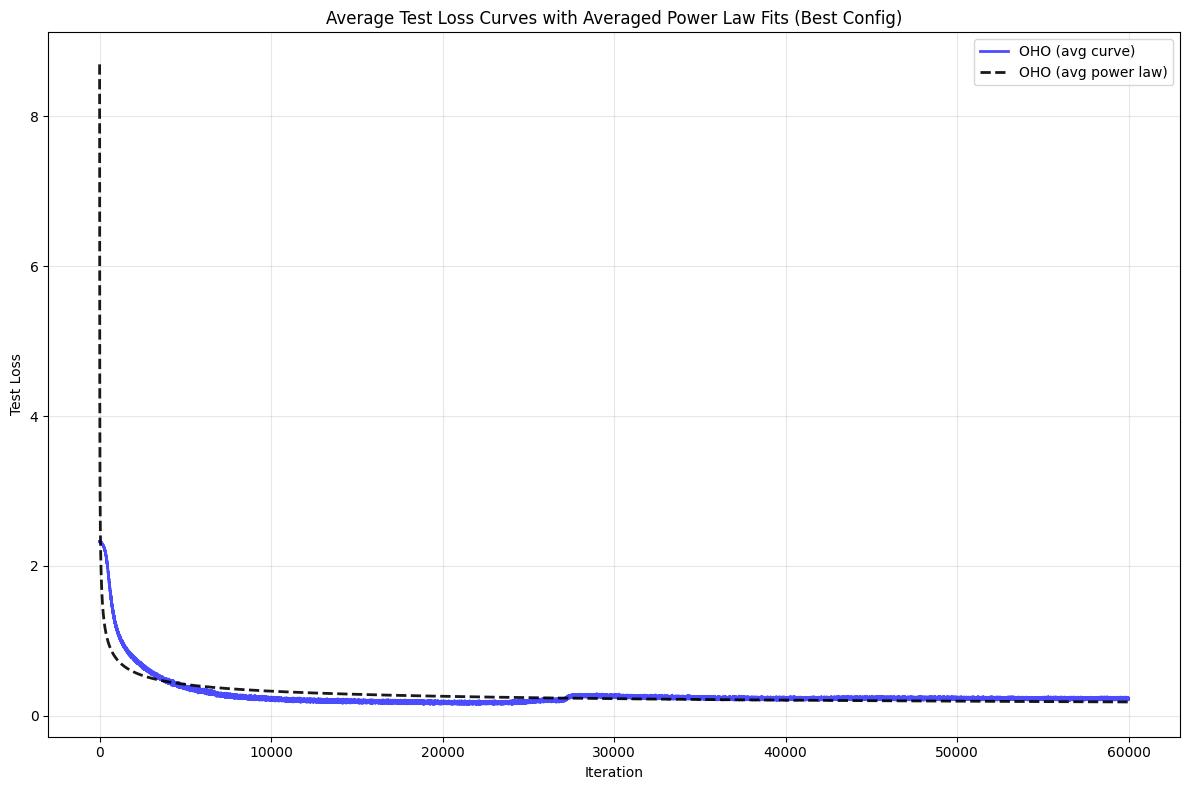

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def power_law(t, a, b, c):
    return a * (t + 1) ** (-b) + c

def plot_average_test_loss_curves_with_powerlaw(experiments):
    """
    Plot average test loss curves with averaged power law fits.
    Fits power law to each task individually, then averages the parameters.
    Uses best config based on learning rate, meta learning rate, and weight decay.
    Memory-efficient version.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")
        color = colors[idx % len(colors)]
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
            # 'config/learners/1/optimizer/momentum',
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        print(f"  Mean final test loss: {best_config['mean']:.6f}")
        print(f"  Number of seeds: {int(best_config['count'])}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id']].compute()
        best_task_ids = best_metadata['task_id'].values
        
        # Get timeseries for best config using Dask
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
        
        # Compute average test loss curve
        avg_curve = best_timeseries.groupby('iteration')['metric/test_loss'].mean()
        iterations = avg_curve.index.values
        avg_test_losses = avg_curve.values
        
        # Fit power law to each individual task and collect parameters
        power_law_params = []
        chunk_size = 10
        
        for i in range(0, len(best_task_ids), chunk_size):
            chunk_ids = best_task_ids[i:i+chunk_size]
            
            for task_id in chunk_ids:
                task_data = best_timeseries[best_timeseries['task_id'] == task_id]
                if len(task_data) > 5:
                    try:
                        task_iterations = task_data['iteration'].values
                        task_losses = task_data['metric/test_loss'].dropna().values
                        if len(task_losses) > 5:
                            popt, _ = curve_fit(power_law, task_iterations[:len(task_losses)], task_losses,
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            power_law_params.append(popt)
                    except:
                        continue
        
        if power_law_params:
            # Average the power law parameters
            avg_a = np.mean([p[0] for p in power_law_params])
            avg_b = np.mean([p[1] for p in power_law_params])
            avg_c = np.mean([p[2] for p in power_law_params])
            
            print(f"  Averaged power law params: a={avg_a:.4f}, b={avg_b:.4f}, c={avg_c:.4f}")
            print(f"  Number of tasks used: {len(power_law_params)}")
            
            # Generate power law curve using averaged parameters
            fitted_curve = power_law(iterations, avg_a, avg_b, avg_c)
            
            # Plot both
            ax.plot(iterations, avg_test_losses, color=color, linewidth=2, alpha=0.7, 
                   label=f'{name} (avg curve)', linestyle='-')
            ax.plot(iterations, fitted_curve, color='black', linewidth=2, alpha=0.9,
                   label=f'{name} (avg power law)', linestyle='--')
        else:
            print(f"  Failed to fit power laws")
            ax.plot(iterations, avg_test_losses, color=color, linewidth=2, 
                   label=f'{name} (avg curve)')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Test Loss')
    ax.set_title('Average Test Loss Curves with Averaged Power Law Fits (Best Config)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



plot_average_test_loss_curves_with_powerlaw(experiments)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

def plot_test_loss_and_lr_curves_by_seed(experiments, smooth_window=100):
    """
    Plot smoothed test loss curves, learning rate curves, and weight decay curves for each seed individually.
    Uses best config based on learning rate, meta learning rate, and weight decay.
    Memory-efficient version.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
        smooth_window: window size for smoothing
    """
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
            # 'config/learners/1/optimizer/momentum'
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'config/seed/global_seed']].compute()
        
        # Get timeseries for best config using Dask
        best_task_ids = best_metadata['task_id'].values
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][
            ['task_id', 'iteration', 'metric/test_loss', 'metric/train_learning_rate', 'metric/train_weight_decay']
        ].compute()
        
        # Merge with metadata to get seeds
        best_timeseries_with_seed = best_timeseries.merge(
            best_metadata[['task_id', 'config/seed/global_seed']], 
            on='task_id'
        )
        
        # Get unique seeds
        seeds = sorted(best_timeseries_with_seed['config/seed/global_seed'].unique())
        print(f"  Number of seeds: {len(seeds)}")
        
        # Create subplots - 3 rows (test loss + LR + weight decay) per seed
        n_seeds = len(seeds)
        n_cols = 5
        n_rows = ((n_seeds + n_cols - 1) // n_cols) * 3  # 3 rows per seed group
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
        axes = axes.reshape(n_rows, n_cols)
        
        # Plot test loss, LR, and weight decay curve for each seed
        for idx, seed in enumerate(seeds):
            col = idx % n_cols
            row_base = (idx // n_cols) * 3
            
            seed_data = best_timeseries_with_seed[
                best_timeseries_with_seed['config/seed/global_seed'] == seed
            ].sort_values('iteration')
            
            iterations = seed_data['iteration'].values
            test_losses = seed_data['metric/test_loss'].values
            
            # Smooth test loss
            smoothed_test_losses = uniform_filter1d(test_losses, size=smooth_window)
            
            # Plot test loss
            axes[row_base, col].plot(iterations, smoothed_test_losses, linewidth=1.5)
            axes[row_base, col].set_xlabel('Iteration')
            axes[row_base, col].set_ylabel('Test Loss (smoothed)')
            axes[row_base, col].set_title(f'Seed {int(seed)} - Test Loss')
            axes[row_base, col].grid(True, alpha=0.3)
            
            # Plot learning rate
            if 'metric/train_learning_rate' in seed_data.columns:
                learning_rates = seed_data['metric/train_learning_rate'].values
                axes[row_base + 1, col].plot(iterations, learning_rates, linewidth=1.5, color='orange')
                axes[row_base + 1, col].set_xlabel('Iteration')
                axes[row_base + 1, col].set_ylabel('Learning Rate')
                axes[row_base + 1, col].set_title(f'Seed {int(seed)} - Learning Rate')
                axes[row_base + 1, col].grid(True, alpha=0.3)
                axes[row_base + 1, col].set_yscale('log')
            else:
                axes[row_base + 1, col].text(0.5, 0.5, 'No LR data', 
                                            ha='center', va='center',
                                            transform=axes[row_base + 1, col].transAxes)
                axes[row_base + 1, col].set_title(f'Seed {int(seed)} - Learning Rate')
            
            # Plot weight decay
            if 'metric/train_weight_decay' in seed_data.columns:
                weight_decays = seed_data['metric/train_weight_decay'].values
                axes[row_base + 2, col].plot(iterations, weight_decays, linewidth=1.5, color='green')
                axes[row_base + 2, col].set_xlabel('Iteration')
                axes[row_base + 2, col].set_ylabel('Weight Decay')
                axes[row_base + 2, col].set_title(f'Seed {int(seed)} - Weight Decay')
                axes[row_base + 2, col].grid(True, alpha=0.3)
                axes[row_base + 2, col].set_yscale('log')
            else:
                axes[row_base + 2, col].text(0.5, 0.5, 'No WD data', 
                                            ha='center', va='center',
                                            transform=axes[row_base + 2, col].transAxes)
                axes[row_base + 2, col].set_title(f'Seed {int(seed)} - Weight Decay')
        
        # Hide unused subplots
        total_used = ((n_seeds + n_cols - 1) // n_cols) * 3
        for row in range(total_used, n_rows):
            for col in range(n_cols):
                axes[row, col].axis('off')
        
        # Hide unused columns in last row group
        last_group_start = (len(seeds) // n_cols) * 3
        used_in_last_group = len(seeds) % n_cols
        if used_in_last_group > 0:
            for col in range(used_in_last_group, n_cols):
                axes[last_group_start, col].axis('off')
                axes[last_group_start + 1, col].axis('off')
                axes[last_group_start + 2, col].axis('off')
        
        fig.suptitle(f'{name}: Test Loss, LR & WD Curves by Seed (smoothing window={smooth_window})\n{config_str}', 
                    fontsize=14)
        plt.tight_layout()
        plt.show()


plot_test_loss_and_lr_curves_by_seed(experiments, smooth_window=100)


Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.000100, weight_decay=0.000010


KeyError: "['metric/train_learning_rate', 'metric/train_weight_decay'] not in index"


Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.000100, weight_decay=0.000010
  Number of seeds: 15


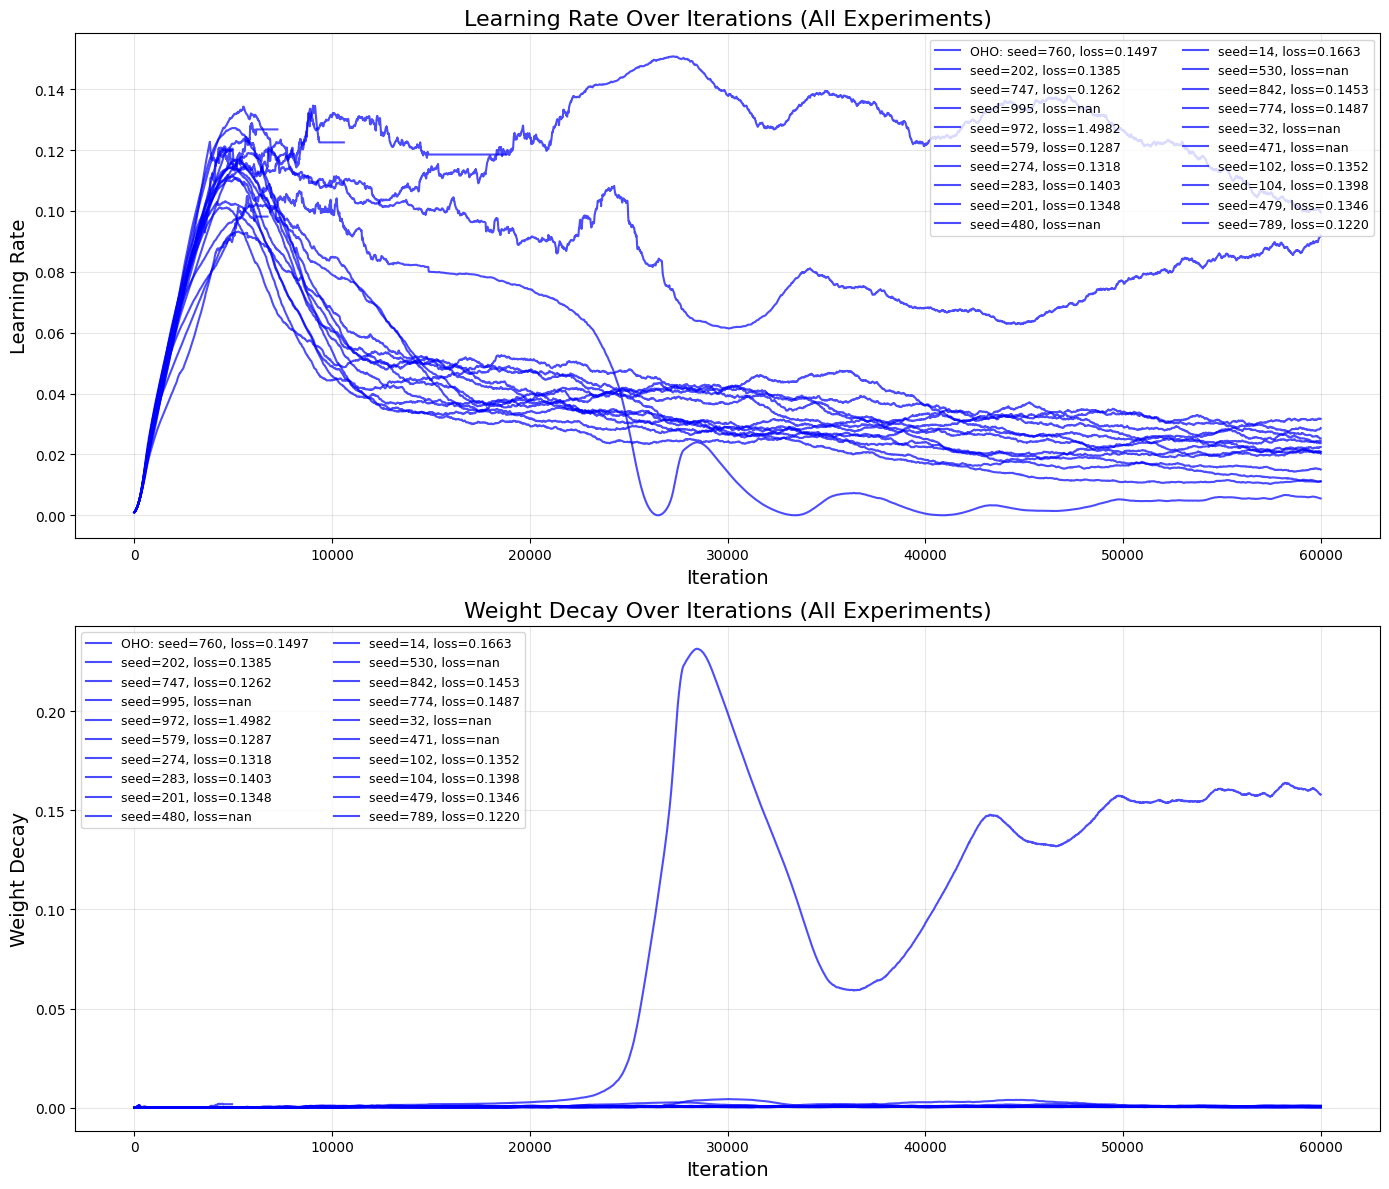

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hyperparameters_for_best_config(experiments):
    """
    Plot learning rates and weight decays over iterations for the best configuration.
    All experiments on same plots with distinct colors and labels.
    Uses best config based on learning rate, meta learning rate, and weight decay.
    Memory-efficient version.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Create distinct colormap for experiments
    exp_colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    for exp_idx, (name, df_metadata, df_timeseries) in enumerate(experiments):
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value',
            # 'config/learners/1/optimizer/momentum'
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        print(f"  Number of seeds: {int(best_config['count'])}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
        
        # Get timeseries for best config tasks
        best_task_ids = best_metadata['task_id'].values
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][
            ['task_id', 'iteration', 'metric/train_recurrent_learning_rate', 'metric/train_recurrent_weight_decay']
        ].compute()
        
        exp_color = exp_colors[exp_idx % len(exp_colors)]
        
        # Plot learning rates and weight decays for each seed
        for seed_idx, (_, row) in enumerate(best_metadata.iterrows()):
            task_id = row['task_id']
            seed = row['config/seed/global_seed']
            final_loss = row['metric/final_test_loss']
            
            task_data = best_timeseries[best_timeseries['task_id'] == task_id].sort_values('iteration')
            
            if len(task_data) > 0:
                iterations = task_data['iteration'].values
                
                # Only show experiment name in label for first seed, then just seed info
                if seed_idx == 0:
                    label_prefix = f"{name}: "
                else:
                    label_prefix = ""
                
                label = f'{label_prefix}seed={seed}, loss={final_loss:.4f}'
                
                # Learning rate
                if 'metric/train_recurrent_learning_rate' in task_data.columns:
                    lrs = task_data['metric/train_recurrent_learning_rate'].values
                    axes[0].plot(iterations, lrs, alpha=0.7, linewidth=1.5, 
                               label=label, color=exp_color)
                
                # Weight decay
                if 'metric/train_recurrent_weight_decay' in task_data.columns:
                    wds = task_data['metric/train_recurrent_weight_decay'].values
                    axes[1].plot(iterations, wds, alpha=0.7, linewidth=1.5, 
                               label=label, color=exp_color)
    
    # Format learning rate plot
    axes[0].set_title("Learning Rate Over Iterations (All Experiments)", fontsize=16)
    axes[0].set_xlabel("Iteration", fontsize=14)
    axes[0].set_ylabel("Learning Rate", fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(fontsize=9, loc='best', ncol=2)
    
    # Format weight decay plot
    axes[1].set_title("Weight Decay Over Iterations (All Experiments)", fontsize=16)
    axes[1].set_xlabel("Iteration", fontsize=14)
    axes[1].set_ylabel("Weight Decay", fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(fontsize=9, loc='best', ncol=2)
    
    plt.tight_layout()
    plt.show()

plot_hyperparameters_for_best_config(experiments)


Processing OHO...
  Using configuration columns: ['config/learners/0/optimizer/learning_rate/value', 'config/learners/1/optimizer/learning_rate/value', 'config/learners/0/optimizer/weight_decay/value']
  Best config: learning_rate=0.001000, learning_rate=0.000100, weight_decay=0.000010
  Number of seeds: 20


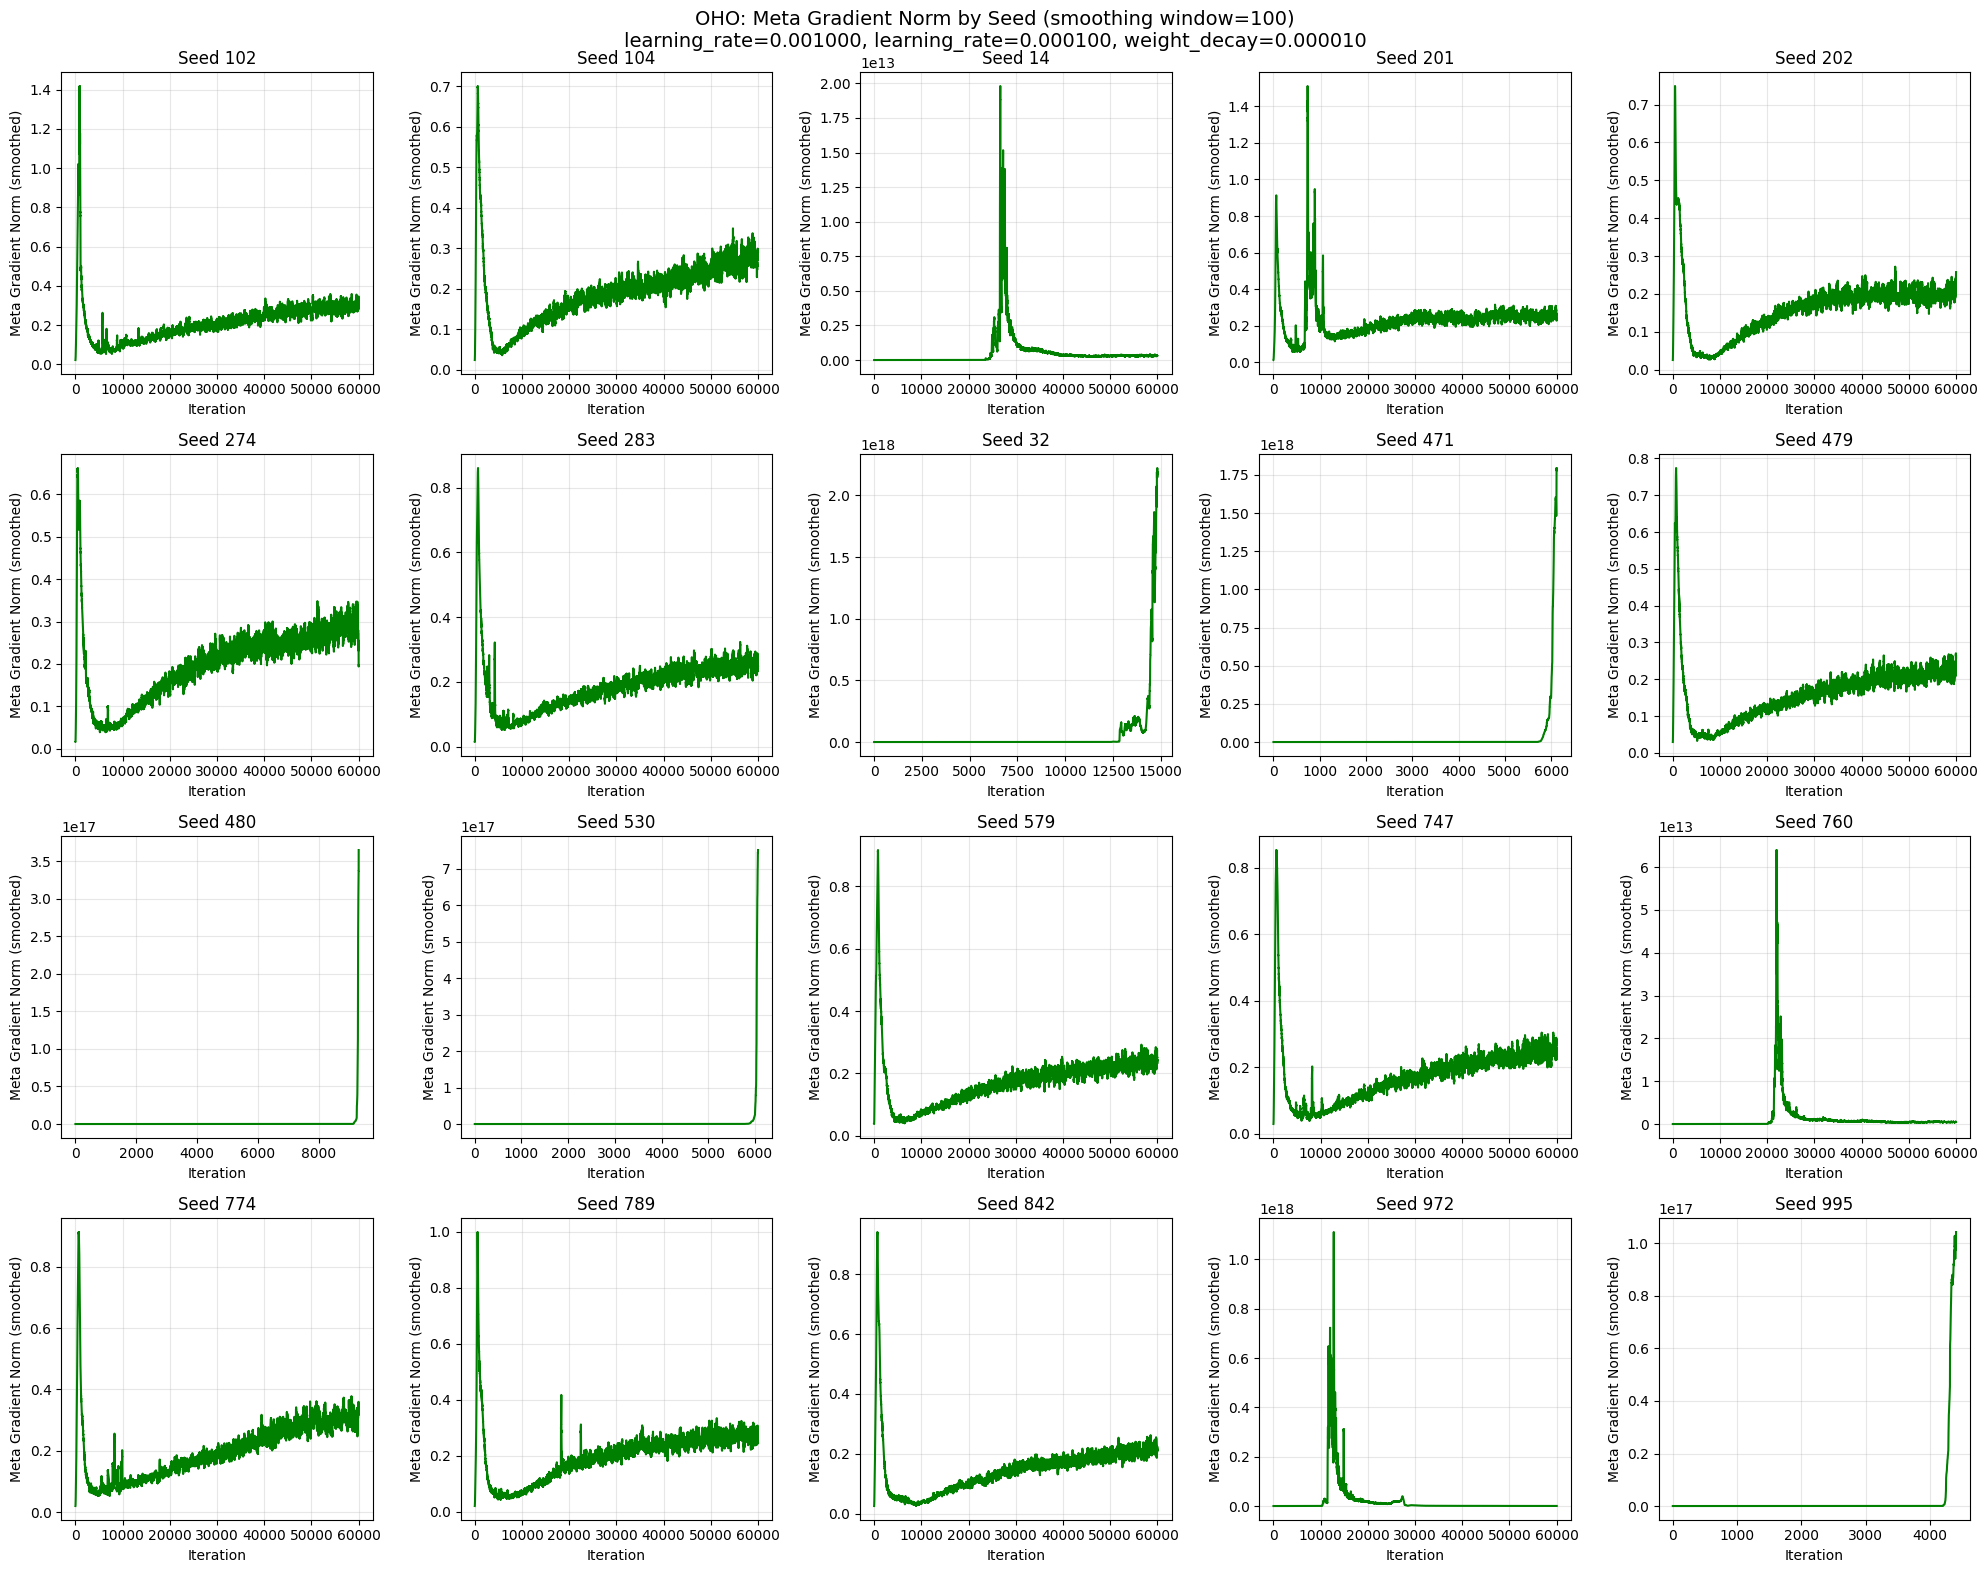

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

def plot_meta_gradient_norm_by_seed(experiments, smooth_window=None):
    """
    Plot meta gradient norm curves for each seed individually.
    Uses best config based on learning rate, meta learning rate, and weight decay.
    Memory-efficient version.
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
        smooth_window: window size for smoothing, None for no smoothing
    """
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value'
        ]
        
        # Check which columns exist
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            print(f"Warning: No configuration columns found.")
            continue
        
        print(f"  Using configuration columns: {available_cols}")
        
        # Find best config using Dask
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        config_str = ", ".join([f"{col.split('/')[-2]}={float(best_config[col]):.6f}" for col in available_cols])
        print(f"  Best config: {config_str}")
        
        # Filter to best config using Dask
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'config/seed/global_seed']].compute()
        
        # Get timeseries for best config using Dask
        best_task_ids = best_metadata['task_id'].values
        best_timeseries = df_timeseries[df_timeseries['task_id'].isin(best_task_ids.tolist())][
            ['task_id', 'iteration', 'metric/meta_gradient_norm']
        ].compute()
        
        # Merge with metadata to get seeds
        best_timeseries_with_seed = best_timeseries.merge(
            best_metadata[['task_id', 'config/seed/global_seed']], 
            on='task_id'
        )
        
        # Get unique seeds
        seeds = sorted(best_timeseries_with_seed['config/seed/global_seed'].unique())
        print(f"  Number of seeds: {len(seeds)}")
        
        # Create subplots
        n_seeds = len(seeds)
        n_cols = 5
        n_rows = (n_seeds + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Plot meta gradient norm for each seed
        for idx, seed in enumerate(seeds):
            row = idx // n_cols
            col = idx % n_cols
            
            seed_data = best_timeseries_with_seed[
                best_timeseries_with_seed['config/seed/global_seed'] == seed
            ].sort_values('iteration')
            
            iterations = seed_data['iteration'].values
            meta_gradient_norms = seed_data['metric/meta_gradient_norm'].values
            
            # Apply smoothing if window specified
            if smooth_window is not None:
                plot_values = uniform_filter1d(meta_gradient_norms, size=smooth_window)
            else:
                plot_values = meta_gradient_norms
            
            axes[row, col].plot(iterations, plot_values, linewidth=1.5, color='green')
            axes[row, col].set_xlabel('Iteration')
            ylabel = 'Meta Gradient Norm' + (' (smoothed)' if smooth_window else '')
            axes[row, col].set_ylabel(ylabel)
            axes[row, col].set_title(f'Seed {int(seed)}')
            axes[row, col].grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(n_seeds, n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            axes[row, col].axis('off')
        
        title = f'{name}: Meta Gradient Norm by Seed'
        if smooth_window:
            title += f' (smoothing window={smooth_window})'
        title += f'\n{config_str}'
        fig.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()


plot_meta_gradient_norm_by_seed(experiments, smooth_window=100)


Processing experiment 1: Fixed LR...
  Best config 1: learning_rate=0.055696, learning_rate=0.001000, weight_decay=0.000938

Processing experiment 2: OHO...
  Best config 2: learning_rate=0.010000, learning_rate=0.001000, weight_decay=0.000010

Number of matching seeds: 20


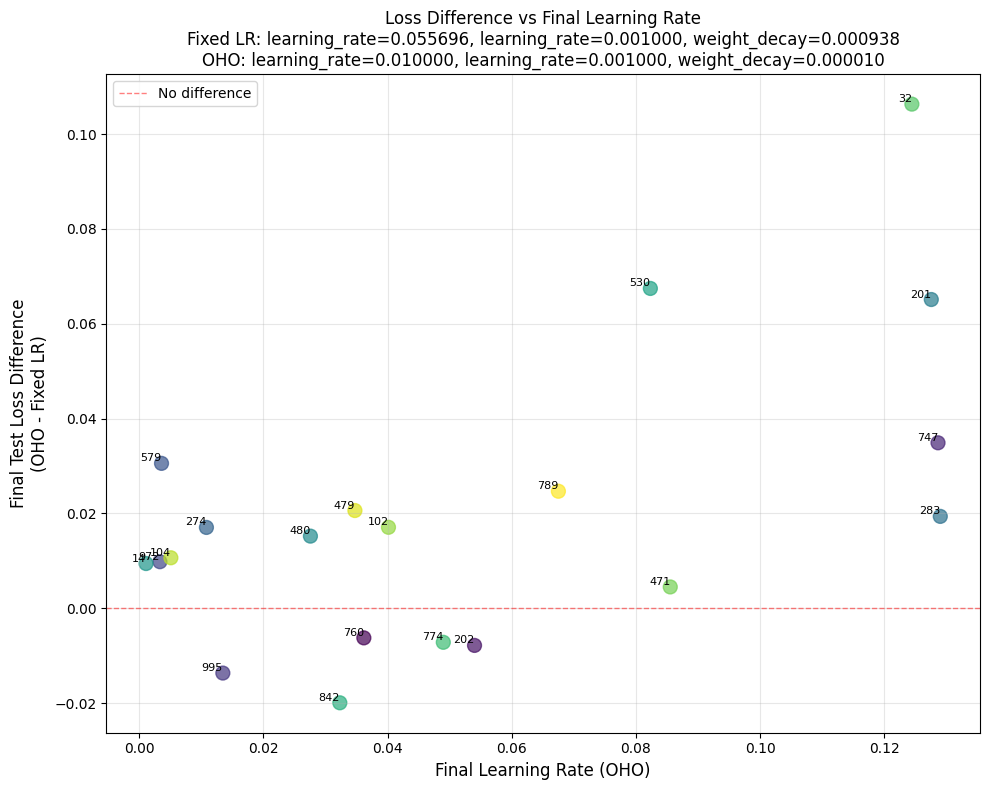


Statistics:
  Mean loss difference: 0.019902
  Std loss difference: 0.029662
  Mean final LR: 0.052811
  Std final LR: 0.044388


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_difference_vs_final_lr(exp1_tuple, exp2_tuple):
    """
    Plot the difference in final test loss (exp2 - exp1) vs final learning rate of exp2.
    Each point represents a seed from the best configs of each experiment.
    
    Args:
        exp1_tuple: tuple (name, df_metadata, df_timeseries) for experiment 1
        exp2_tuple: tuple (name, df_metadata, df_timeseries) for experiment 2
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing experiment 1: {name1}...")
    
    # Get best config for experiment 1
    config_cols = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    
    available_cols1 = [col for col in config_cols if col in df_metadata1.columns]
    config_summary1 = df_metadata1.groupby(available_cols1)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary1 = config_summary1.reset_index().sort_values('mean')
    best_config1 = config_summary1.iloc[0]
    
    config_str1 = ", ".join([f"{col.split('/')[-2]}={float(best_config1[col]):.6f}" for col in available_cols1])
    print(f"  Best config 1: {config_str1}")
    
    # Filter to best config for exp1
    mask1 = df_metadata1[available_cols1[0]] == best_config1[available_cols1[0]]
    for col in available_cols1[1:]:
        mask1 &= (df_metadata1[col] == best_config1[col])
    best_metadata1 = df_metadata1[mask1][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    print(f"\nProcessing experiment 2: {name2}...")
    
    # Get best config for experiment 2
    available_cols2 = [col for col in config_cols if col in df_metadata2.columns]
    config_summary2 = df_metadata2.groupby(available_cols2)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary2 = config_summary2.reset_index().sort_values('mean')
    best_config2 = config_summary2.iloc[0]
    
    config_str2 = ", ".join([f"{col.split('/')[-2]}={float(best_config2[col]):.6f}" for col in available_cols2])
    print(f"  Best config 2: {config_str2}")
    
    # Filter to best config for exp2
    mask2 = df_metadata2[available_cols2[0]] == best_config2[available_cols2[0]]
    for col in available_cols2[1:]:
        mask2 &= (df_metadata2[col] == best_config2[col])
    best_metadata2 = df_metadata2[mask2][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    # Get final learning rates for exp2
    best_task_ids2 = best_metadata2['task_id'].values
    best_timeseries2 = df_timeseries2[df_timeseries2['task_id'].isin(best_task_ids2.tolist())][
        ['task_id', 'iteration', 'metric/train_learning_rate']
    ].compute()
    
    # Build mapping from seed to data
    seed_to_loss1 = dict(zip(best_metadata1['config/seed/global_seed'], best_metadata1['metric/final_test_loss']))
    seed_to_loss2 = dict(zip(best_metadata2['config/seed/global_seed'], best_metadata2['metric/final_test_loss']))
    
    # Get final LR for each task in exp2
    final_lrs = []
    loss_diffs = []
    seeds_plotted = []
    
    for _, row in best_metadata2.iterrows():
        task_id = row['task_id']
        seed = row['config/seed/global_seed']
        loss2 = row['metric/final_test_loss']
        
        # Check if this seed exists in exp1
        if seed in seed_to_loss1:
            loss1 = seed_to_loss1[seed]
            
            # Get final learning rate for this task
            task_data = best_timeseries2[best_timeseries2['task_id'] == task_id]
            if len(task_data) > 0 and 'metric/train_learning_rate' in task_data.columns:
                task_data_sorted = task_data.sort_values('iteration')
                final_lr = task_data_sorted['metric/train_learning_rate'].iloc[-1]
                
                final_lrs.append(final_lr)
                loss_diffs.append(loss2 - loss1)
                seeds_plotted.append(seed)
    
    print(f"\nNumber of matching seeds: {len(seeds_plotted)}")
    
    # Create scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    scatter = ax.scatter(final_lrs, loss_diffs, s=100, alpha=0.7, c=range(len(final_lrs)), cmap='viridis')
    
    # Annotate points with seed numbers
    for i, seed in enumerate(seeds_plotted):
        ax.annotate(f'{int(seed)}', (final_lrs[i], loss_diffs[i]), 
                   fontsize=8, ha='right', va='bottom')
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No difference')
    
    ax.set_xlabel(f'Final Learning Rate ({name2})', fontsize=12)
    ax.set_ylabel(f'Final Test Loss Difference\n({name2} - {name1})', fontsize=12)
    ax.set_title(f'Loss Difference vs Final Learning Rate\n{name1}: {config_str1}\n{name2}: {config_str2}', 
                fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics:")
    print(f"  Mean loss difference: {np.mean(loss_diffs):.6f}")
    print(f"  Std loss difference: {np.std(loss_diffs):.6f}")
    print(f"  Mean final LR: {np.mean(final_lrs):.6f}")
    print(f"  Std final LR: {np.std(final_lrs):.6f}")

# Example usage:
plot_loss_difference_vs_final_lr(experiments[0], experiments[1])


Processing experiment 1: Fixed LR...
  Found 100 unique configs in experiment 1
  LR range: 0.001000 to 0.300000
  WD range: 0.000010 to 0.010000
  Loss range: 0.138308 to 1.431610

Processing experiment 2: OHO...
  Best config 2: learning_rate=0.010000, learning_rate=0.001000, weight_decay=0.000010
  Best mean final test loss: 0.158210

Getting trajectory for best OHO config...
  Found 3 runs with best config, using first 3 seeds
  Seed 760: 60000 points
    LR range: 0.010000 to 0.067286
    WD range: 0.000001 to 0.000887
  Seed 202: 60000 points
    LR range: 0.010000 to 0.104601
    WD range: 0.000001 to 0.000341
  Seed 747: 60000 points
    LR range: 0.010000 to 0.129807
    WD range: 0.000001 to 0.000221


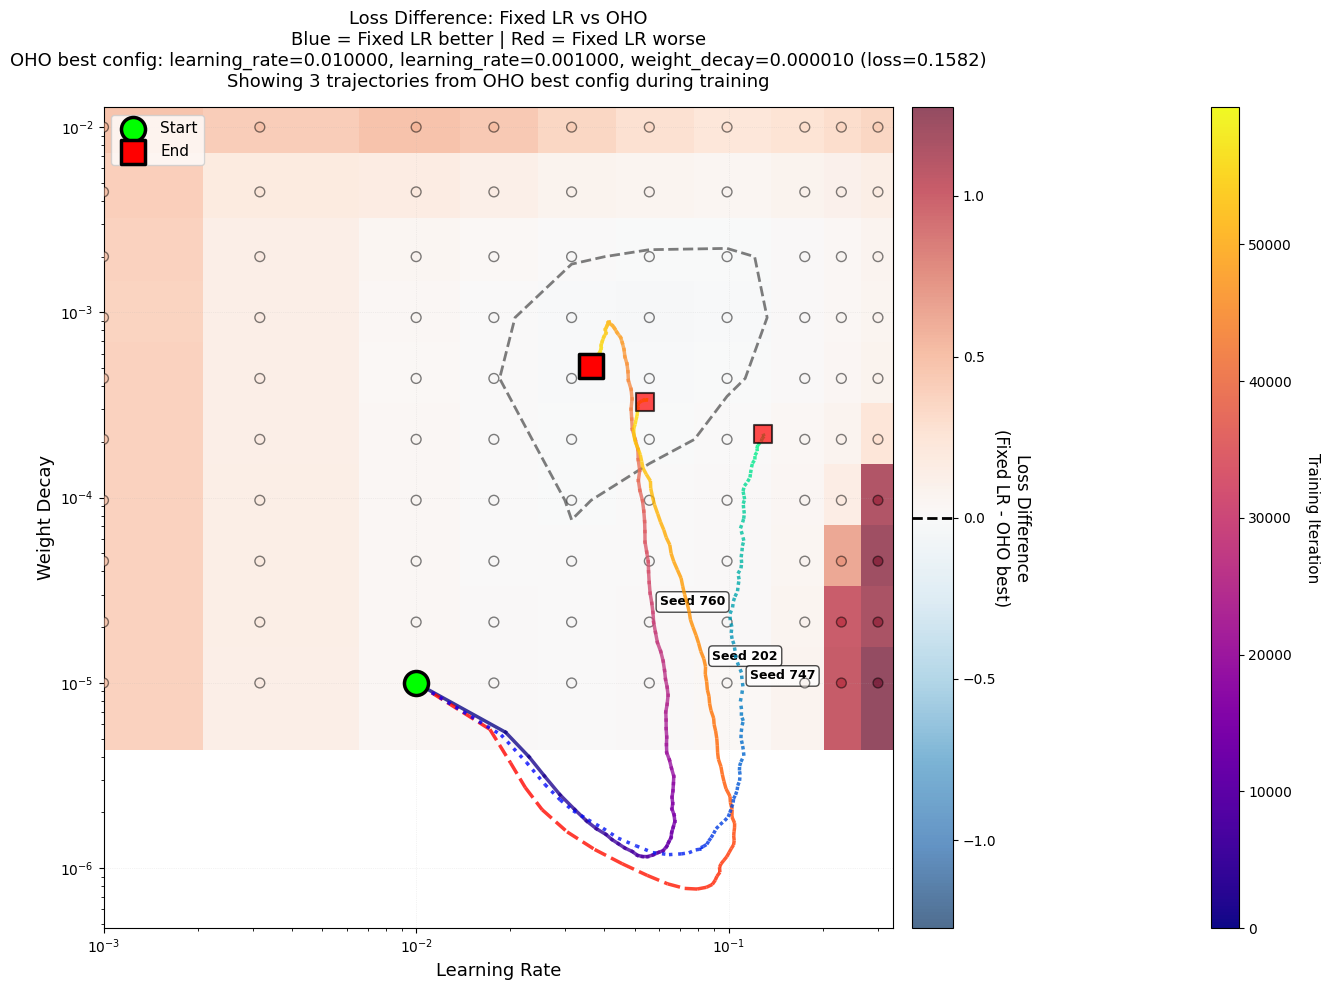


Comparison:
  Exp1 best loss: 0.138308
  Exp2 best loss: 0.158210
  Difference (exp2 - exp1 best): 0.019902
  Configs in exp1 better than exp2: 11/100
  Configs in exp1 worse than exp2: 89/100
  Mean difference: 0.181455
  Max improvement (most negative): -0.019902
  Max degradation (most positive): 1.273400


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

def plot_3d_loss_landscape_with_trajectory(exp1_tuple, exp2_tuple):
    """
    Plot difference heatmap showing (exp1_loss - exp2_best_loss) for each config,
    with trajectory of best exp2 config's LR and WD over training iterations.
    
    Args:
        exp1_tuple: tuple (name, df_metadata, df_timeseries) for experiment 1
        exp2_tuple: tuple (name, df_metadata, df_timeseries) for experiment 2
    """
    name1, df_metadata1, df_timeseries1 = exp1_tuple
    name2, df_metadata2, df_timeseries2 = exp2_tuple
    
    print(f"\nProcessing experiment 1: {name1}...")
    
    # For exp1: group by LR and weight decay (ignore meta LR)
    config_cols1 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    
    available_cols1 = [col for col in config_cols1 if col in df_metadata1.columns]
    
    if len(available_cols1) < 2:
        print(f"Error: Need both learning rate and weight decay columns")
        print(f"Available columns: {available_cols1}")
        return
    
    # Get all configs for exp1 with mean final test loss
    config_summary1 = df_metadata1.groupby(available_cols1)['metric/final_test_loss'].agg(['mean', 'std', 'count']).compute()
    config_summary1 = config_summary1.reset_index()
    
    print(f"  Found {len(config_summary1)} unique configs in experiment 1")
    
    # Extract LR, WD, and loss values - convert to float
    lrs = config_summary1[available_cols1[0]].astype(float).values
    wds = config_summary1[available_cols1[1]].astype(float).values
    losses = config_summary1['mean'].values
    
    print(f"  LR range: {lrs.min():.6f} to {lrs.max():.6f}")
    print(f"  WD range: {wds.min():.6f} to {wds.max():.6f}")
    print(f"  Loss range: {losses.min():.6f} to {losses.max():.6f}")
    
    print(f"\nProcessing experiment 2: {name2}...")
    
    # For exp2: get best config (using all available config columns)
    config_cols2 = [
        'config/learners/0/optimizer/learning_rate/value',
        'config/learners/1/optimizer/learning_rate/value',
        'config/learners/0/optimizer/weight_decay/value'
    ]
    
    available_cols2 = [col for col in config_cols2 if col in df_metadata2.columns]
    config_summary2 = df_metadata2.groupby(available_cols2)['metric/final_test_loss'].agg(['mean', 'count']).compute()
    config_summary2 = config_summary2.reset_index().sort_values('mean')
    best_config2 = config_summary2.iloc[0]
    best_loss2 = best_config2['mean']
    
    config_str2 = ", ".join([f"{col.split('/')[-2]}={float(best_config2[col]):.6f}" for col in available_cols2])
    print(f"  Best config 2: {config_str2}")
    print(f"  Best mean final test loss: {best_loss2:.6f}")
    
    # Get the trajectory data for the best exp2 config
    print(f"\nGetting trajectory for best {name2} config...")
    
    # Filter metadata to get task_ids for best config
    mask_meta = df_metadata2[available_cols2[0]] == best_config2[available_cols2[0]]
    for col in available_cols2[1:]:
        if col in df_metadata2.columns:
            mask_meta = mask_meta & (df_metadata2[col] == best_config2[col])
    
    best_metadata = df_metadata2[mask_meta][['task_id', 'config/seed/global_seed', 'metric/final_test_loss']].compute()
    
    # Only use first 3 seeds
    best_metadata = best_metadata.head(3)
    best_task_ids = best_metadata['task_id'].values
    
    print(f"  Found {len(best_metadata)} runs with best config, using first 3 seeds")
    
    # Get timeseries data for these tasks
    best_timeseries = df_timeseries2[df_timeseries2['task_id'].isin(best_task_ids.tolist())].compute()
    
    # Plot trajectories for all 3 seeds
    trajectories = []
    
    for task_idx, task_id in enumerate(best_task_ids):
        task_data = best_timeseries[best_timeseries['task_id'] == task_id].sort_values('iteration')
        seed = best_metadata[best_metadata['task_id'] == task_id]['config/seed/global_seed'].values[0]
        
        # Look for the actual metric columns in timeseries
        lr_col = 'metric/train_learning_rate'
        wd_col = 'metric/train_weight_decay'
        
        if lr_col in task_data.columns and wd_col in task_data.columns:
            trajectory_lr = task_data[lr_col].values
            trajectory_wd = task_data[wd_col].values
            trajectory_iterations = task_data['iteration'].values
            
            trajectories.append({
                'lr': trajectory_lr,
                'wd': trajectory_wd,
                'iterations': trajectory_iterations,
                'seed': seed,
                'task_id': task_id
            })
            
            print(f"  Seed {seed}: {len(trajectory_lr)} points")
            print(f"    LR range: {np.nanmin(trajectory_lr):.6f} to {np.nanmax(trajectory_lr):.6f}")
            print(f"    WD range: {np.nanmin(trajectory_wd):.6f} to {np.nanmax(trajectory_wd):.6f}")
        else:
            print(f"  Warning: Could not find trajectory columns for task {task_id}")
    
    if not trajectories:
        print("  Warning: No trajectory data found")
        trajectory_lr = None
        trajectory_wd = None
    else:
        # Use first trajectory as main one for compatibility
        trajectory_lr = trajectories[0]['lr']
        trajectory_wd = trajectories[0]['wd']
    
    # Calculate differences
    loss_differences = losses - best_loss2
    
    # Get unique LR and WD values for grid
    lr_unique = np.sort(np.unique(lrs))
    wd_unique = np.sort(np.unique(wds))
    
    # Create grid for heatmap
    LR_grid, WD_grid = np.meshgrid(lr_unique, wd_unique)
    Diff_grid = np.full(LR_grid.shape, np.nan)
    
    # Fill in the difference values
    for i, lr in enumerate(lr_unique):
        for j, wd in enumerate(wd_unique):
            mask = (lrs == lr) & (wds == wd)
            if np.any(mask):
                Diff_grid[j, i] = loss_differences[mask][0]
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Use RdBu_r colormap (red for positive/worse, blue for negative/better)
    max_abs_diff = np.nanmax(np.abs(loss_differences))
    
    im = ax.pcolormesh(LR_grid, WD_grid, Diff_grid, 
                       cmap='RdBu_r', shading='auto',
                       vmin=-max_abs_diff, vmax=max_abs_diff, alpha=0.7)
    
    # Add contour line at zero (where exp1 = exp2)
    contour = ax.contour(LR_grid, WD_grid, Diff_grid, levels=[0], 
                        colors='black', linewidths=2, linestyles='--', alpha=0.5)
    
    # Add scatter points to show actual configs
    scatter = ax.scatter(lrs, wds, c=loss_differences, 
                        cmap='RdBu_r', s=50, edgecolors='black', linewidths=1,
                        vmin=-max_abs_diff, vmax=max_abs_diff, zorder=5, alpha=0.5)
    
    # Plot trajectories if available
    if trajectories:
        # Use different line styles for each seed
        line_styles = ['-', '--', ':']
        seed_colors = ['purple', 'orange', 'cyan']
        
        for traj_idx, traj in enumerate(trajectories):
            trajectory_lr = traj['lr']
            trajectory_wd = traj['wd']
            seed = traj['seed']
            
            # Remove NaN values
            valid_mask = ~(np.isnan(trajectory_lr) | np.isnan(trajectory_wd))
            trajectory_lr = trajectory_lr[valid_mask]
            trajectory_wd = trajectory_wd[valid_mask]
            
            if len(trajectory_lr) > 0:
                # Subsample if too many points
                if len(trajectory_lr) > 100:
                    indices = np.linspace(0, len(trajectory_lr)-1, 100, dtype=int)
                    traj_lr_plot = trajectory_lr[indices]
                    traj_wd_plot = trajectory_wd[indices]
                else:
                    traj_lr_plot = trajectory_lr
                    traj_wd_plot = trajectory_wd
                
                # Create color gradient for time (unique for each seed)
                base_color = seed_colors[traj_idx % len(seed_colors)]
                if base_color == 'purple':
                    colors = plt.cm.plasma(np.linspace(0, 1, len(traj_lr_plot)))
                elif base_color == 'orange':
                    colors = plt.cm.autumn(np.linspace(0, 1, len(traj_lr_plot)))
                else:  # cyan
                    colors = plt.cm.winter(np.linspace(0, 1, len(traj_lr_plot)))
                
                # Plot trajectory as line with gradient
                for i in range(len(traj_lr_plot) - 1):
                    ax.plot(traj_lr_plot[i:i+2], traj_wd_plot[i:i+2], 
                           color=colors[i], linewidth=2.5, zorder=15, alpha=0.8,
                           linestyle=line_styles[traj_idx % len(line_styles)])
                
                # Mark start point with circle (only for first trajectory for clarity)
                if traj_idx == 0:
                    ax.scatter(traj_lr_plot[0], traj_wd_plot[0], 
                              s=300, c='lime', marker='o', edgecolors='black', 
                              linewidths=2.5, zorder=20, label='Start')
                    
                    # Mark end point with square
                    ax.scatter(traj_lr_plot[-1], traj_wd_plot[-1], 
                              s=300, c='red', marker='s', edgecolors='black', 
                              linewidths=2.5, zorder=20, label='End')
                else:
                    # Smaller markers for other seeds
                    ax.scatter(traj_lr_plot[0], traj_wd_plot[0], 
                              s=150, c='lime', marker='o', edgecolors='black', 
                              linewidths=1.5, zorder=19, alpha=0.7)
                    ax.scatter(traj_lr_plot[-1], traj_wd_plot[-1], 
                              s=150, c='red', marker='s', edgecolors='black', 
                              linewidths=1.5, zorder=19, alpha=0.7)
                
                # Add seed label at midpoint
                mid_idx = len(traj_lr_plot) // 2
                ax.annotate(f'Seed {seed}', 
                          xy=(traj_lr_plot[mid_idx], traj_wd_plot[mid_idx]),
                          xytext=(5, 5), textcoords='offset points',
                          fontsize=9, color='black', weight='bold',
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
        
        # Add time colorbar (just one, representing general progression)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, 
                                   norm=plt.Normalize(vmin=0, vmax=len(trajectories[0]['lr'])-1))
        sm.set_array([])
        cbar_time = fig.colorbar(sm, ax=ax, pad=0.12, aspect=30)
        cbar_time.set_label('Training Iteration', fontsize=11, rotation=270, labelpad=20)
        
        ax.legend(loc='best', fontsize=11)
    
    # Main colorbar for differences
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label(f'Loss Difference\n({name1} - {name2} best)', fontsize=12, rotation=270, labelpad=25)
    cbar.ax.axhline(y=0, color='black', linewidth=2, linestyle='--')
    
    # Labels and title
    ax.set_xlabel('Learning Rate', fontsize=13)
    ax.set_ylabel('Weight Decay', fontsize=13)
    
    title = f'Loss Difference: {name1} vs {name2}\n'
    title += f'Blue = {name1} better | Red = {name1} worse\n'
    title += f'{name2} best config: {config_str2} (loss={best_loss2:.4f})'
    if trajectories:
        title += f'\nShowing 3 trajectories from {name2} best config during training'
    
    ax.set_title(title, fontsize=13, pad=15)
    
    # Use log scale if appropriate
    if lrs.min() > 0 and lrs.max() / lrs.min() > 10:
        ax.set_xscale('log')
    if wds.min() > 0 and wds.max() / wds.min() > 10:
        ax.set_yscale('log')
    
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nComparison:")
    print(f"  Exp1 best loss: {losses.min():.6f}")
    print(f"  Exp2 best loss: {best_loss2:.6f}")
    print(f"  Difference (exp2 - exp1 best): {best_loss2 - losses.min():.6f}")
    print(f"  Configs in exp1 better than exp2: {np.sum(loss_differences < 0)}/{len(loss_differences)}")
    print(f"  Configs in exp1 worse than exp2: {np.sum(loss_differences > 0)}/{len(loss_differences)}")
    print(f"  Mean difference: {np.mean(loss_differences):.6f}")
    print(f"  Max improvement (most negative): {np.min(loss_differences):.6f}")
    print(f"  Max degradation (most positive): {np.max(loss_differences):.6f}")

# Example usage:
plot_3d_loss_landscape_with_trajectory(experiments[0], experiments[1])

In [11]:
import numpy as np
from scipy.stats import mannwhitneyu

def compare_experiments_mann_whitney(experiments):
    """
    Compare experiments pairwise using Mann-Whitney U test for:
    - Final test loss
    - Effective learning rate (decay rate b)
    - Asymptotic loss (c parameter)
    
    Args:
        experiments: list of tuples (name, df_metadata, df_timeseries)
    """
    n_experiments = len(experiments)
    
    # Collect data for each experiment's best config
    experiment_data = []
    
    for name, df_metadata, df_timeseries in experiments:
        print(f"\nProcessing {name}...")
        
        config_cols = [
            'config/learners/0/optimizer/learning_rate/value',
            'config/learners/1/optimizer/learning_rate/value',
            'config/learners/0/optimizer/weight_decay/value'
        ]
        
        available_cols = [col for col in config_cols if col in df_metadata.columns]
        
        if len(available_cols) == 0:
            continue
        
        # Get best config
        config_summary = df_metadata.groupby(available_cols)['metric/final_test_loss'].agg(['mean', 'count']).compute()
        config_summary = config_summary.reset_index().sort_values('mean')
        best_config = config_summary.iloc[0]
        
        # Filter to best config
        mask = df_metadata[available_cols[0]] == best_config[available_cols[0]]
        for col in available_cols[1:]:
            mask &= (df_metadata[col] == best_config[col])
        best_metadata = df_metadata[mask][['task_id', 'metric/final_test_loss']].compute()
        
        final_losses = best_metadata['metric/final_test_loss'].dropna().values
        best_task_ids = best_metadata['task_id'].values
        
        # Compute effective LRs and asymptotes
        eff_lrs = []
        asymptotes = []
        chunk_size = 10
        
        for i in range(0, len(best_task_ids), chunk_size):
            chunk_ids = best_task_ids[i:i+chunk_size]
            chunk_timeseries = df_timeseries[df_timeseries['task_id'].isin(chunk_ids.tolist())][['task_id', 'iteration', 'metric/test_loss']].compute()
            
            for task_id in chunk_ids:
                task_data = chunk_timeseries[chunk_timeseries['task_id'] == task_id]
                if len(task_data) > 5:
                    try:
                        from scipy.optimize import curve_fit
                        iterations = task_data['iteration'].values
                        test_losses = task_data['metric/test_loss'].dropna().values
                        if len(test_losses) > 5:
                            popt, _ = curve_fit(power_law, iterations[:len(test_losses)], test_losses,
                                              bounds=([0,0,0], [np.inf,np.inf,np.inf]), maxfev=2000)
                            eff_lrs.append(popt[1])
                            asymptotes.append(popt[2])
                    except:
                        continue
        
        experiment_data.append({
            'name': name,
            'final_losses': np.array(final_losses),
            'eff_lrs': np.array(eff_lrs),
            'asymptotes': np.array(asymptotes)
        })
    
    # Pairwise comparisons
    print(f"\n{'='*80}")
    print("MANN-WHITNEY U TEST RESULTS (Pairwise Comparisons)")
    print(f"{'='*80}\n")
    
    for i in range(n_experiments):
        for j in range(i + 1, n_experiments):
            name1 = experiment_data[i]['name']
            name2 = experiment_data[j]['name']
            
            print(f"\n{name1} vs {name2}")
            print("-" * 80)
            
            # Final test loss (lower is better)
            stat, p = mannwhitneyu(experiment_data[i]['final_losses'], 
                                   experiment_data[j]['final_losses'], 
                                   alternative='two-sided')
            median1 = np.median(experiment_data[i]['final_losses'])
            median2 = np.median(experiment_data[j]['final_losses'])
            winner = name1 if median1 < median2 else name2
            print(f"Final Test Loss:")
            print(f"  U-statistic: {stat:.2f}")
            print(f"  p-value: {p:.6f}")
            print(f"  Significant (p<0.05): {'YES' if p < 0.05 else 'NO'}")
            print(f"  Medians: {median1:.6f} vs {median2:.6f}")
            print(f"  WINNER: {winner} (lower is better)")
            
            # Effective learning rate (higher is better - faster convergence)
            if len(experiment_data[i]['eff_lrs']) > 0 and len(experiment_data[j]['eff_lrs']) > 0:
                stat, p = mannwhitneyu(experiment_data[i]['eff_lrs'], 
                                       experiment_data[j]['eff_lrs'], 
                                       alternative='two-sided')
                median1 = np.median(experiment_data[i]['eff_lrs'])
                median2 = np.median(experiment_data[j]['eff_lrs'])
                winner = name1 if median1 > median2 else name2
                print(f"\nEffective Learning Rate (Decay Rate b):")
                print(f"  U-statistic: {stat:.2f}")
                print(f"  p-value: {p:.6f}")
                print(f"  Significant (p<0.05): {'YES' if p < 0.05 else 'NO'}")
                print(f"  Medians: {median1:.6f} vs {median2:.6f}")
                print(f"  WINNER: {winner} (higher is better)")
            else:
                print(f"\nEffective Learning Rate: Insufficient data")
            
            # Asymptotic loss (lower is better)
            if len(experiment_data[i]['asymptotes']) > 0 and len(experiment_data[j]['asymptotes']) > 0:
                stat, p = mannwhitneyu(experiment_data[i]['asymptotes'], 
                                       experiment_data[j]['asymptotes'], 
                                       alternative='two-sided')
                median1 = np.median(experiment_data[i]['asymptotes'])
                median2 = np.median(experiment_data[j]['asymptotes'])
                winner = name1 if median1 < median2 else name2
                print(f"\nAsymptotic Loss (c):")
                print(f"  U-statistic: {stat:.2f}")
                print(f"  p-value: {p:.6f}")
                print(f"  Significant (p<0.05): {'YES' if p < 0.05 else 'NO'}")
                print(f"  Medians: {median1:.6f} vs {median2:.6f}")
                print(f"  WINNER: {winner} (lower is better)")
            else:
                print(f"\nAsymptotic Loss: Insufficient data")

compare_experiments_mann_whitney(experiments)


Processing Fixed LR...

Processing OHO...

MANN-WHITNEY U TEST RESULTS (Pairwise Comparisons)


Fixed LR vs OHO
--------------------------------------------------------------------------------
Final Test Loss:
  U-statistic: 92.00
  p-value: 0.003639
  Significant (p<0.05): YES
  Medians: 0.141568 vs 0.148650
  WINNER: Fixed LR (lower is better)

Effective Learning Rate (Decay Rate b):
  U-statistic: 79.00
  p-value: 0.001116
  Significant (p<0.05): YES
  Medians: 0.364197 vs 0.381323
  WINNER: OHO (higher is better)

Asymptotic Loss (c):
  U-statistic: 229.00
  p-value: 0.440750
  Significant (p<0.05): NO
  Medians: 0.000000 vs 0.000000
  WINNER: OHO (lower is better)
